**Write the names of all group members (max. 5 members)**:
- Lucas, Gimeno
- Nils, Johnson
- Hai Yen, Van
- Matteo, Bodmer
- Jonas, Isler

When submitting your work, please follow closely the template below.

# Exercise 1 (Poisson GLM)

### Question 1.a

In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_poisson_deviance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Detect device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cuda


In [4]:
# Read csv file `freMTPL2freq.csv` (e.g. use pandas)
# Use semicolon separator and comma decimal (common for this dataset)
dataframe = pd.read_csv('freMTPL2freq.csv', sep=';', decimal=',', encoding='utf-8')
print(dataframe.head())
# extracrt features X and target y from the dataframe
X_full = dataframe[["VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"]]
y_full = dataframe[["Exposure", "ClaimNb"]]
y_full["ClaimFrequency"] = y_full["ClaimNb"]/y_full["Exposure"]
# print data sizes
print(f'head of X (full dataset) is {X_full.head()} with sieze {X_full.shape}')
print(f'head of y (full dataset) is {y_full.head()} with sieze {y_full.shape}')

   VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density Region  \
0         4       9       23         100       B6  Regular     7887    R31   
1         4       6       26         100       B6  Regular     2308    R31   
2         4       6       26         100       B6  Regular     2308    R31   
3         7       4       44          50       B6  Regular       37    R94   
4         5       2       29          90       B6  Regular      335    R91   

   Exposure  ClaimNb  
0      0.76        0  
1      0.74        0  
2      0.11        0  
3      0.83        0  
4      0.69        0  
head of X (full dataset) is    VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density Region
0         4       9       23         100       B6  Regular     7887    R31
1         4       6       26         100       B6  Regular     2308    R31
2         4       6       26         100       B6  Regular     2308    R31
3         7       4       44          50       B6  Regular       

C:\Users\Lucas\AppData\Local\Temp\ipykernel_22312\2005146420.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_full["ClaimFrequency"] = y_full["ClaimNb"]/y_full["Exposure"]


In [5]:
# One-hot encode categorical variables and standardize numeric features on full data
categorical_cols = ['VehBrand', 'VehGas', 'Region']
numeric_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

# Create dummies for categorical variables (done on full data to ensure consistent columns)
X_encoded = pd.get_dummies(X_full, columns=categorical_cols, drop_first=False)
print(f'X_encoded shape after encoding: {X_encoded.shape}')

# Standardize numeric columns on full data
X_scaler = StandardScaler()
X_encoded[numeric_cols] = X_scaler.fit_transform(X_encoded[numeric_cols])
print(f'X_encoded shape after standardization: {X_encoded.shape}')
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_full, test_size=0.1, random_state=42)
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')

# Train a Poisson GLM
# You can use sklearn.linear_model.PoissonRegressor
glm = PoissonRegressor(alpha=0.0) # intercept is True by default
glm.fit(X_train, y_train["ClaimFrequency"], sample_weight=y_train["Exposure"])
# Print MAE, MSE and loss on train and test data sets
print("average MARE on train:", mean_absolute_error(y_train["ClaimFrequency"], glm.predict(X_train), sample_weight=y_train["Exposure"]))
print("average MSE on train:", mean_squared_error(y_train["ClaimFrequency"], glm.predict(X_train), sample_weight=y_train["Exposure"]))
print("mean Poisson deviance on test data: %.3f" % mean_poisson_deviance (y_train['ClaimFrequency'], glm.predict(X_train), sample_weight=y_train['Exposure']))



X_encoded shape after encoding: (678007, 40)
X_encoded shape after standardization: (678007, 40)
X_train shape: (610206, 40), X_test shape: (67801, 40)
average MARE on train: 0.13828499965098284
average MSE on train: 0.23555100657378364
mean Poisson deviance on test data: 0.459


In [6]:
# Test Set, sample_weight=y_test["Exposure"]
# Print MAE, MSE and loss on train and test data sets
print("average MARE on test:", mean_absolute_error(y_test["ClaimFrequency"], glm.predict(X_test), sample_weight=y_test["Exposure"]))
print("average MSE on test:", mean_squared_error(y_test["ClaimFrequency"], glm.predict(X_test), sample_weight=y_test["Exposure"]))
print("mean Poisson deviance on test data: %.3f" % mean_poisson_deviance (y_test['ClaimFrequency'], glm.predict(X_test), sample_weight=y_test['Exposure']))

average MARE on test: 0.13631781211060318
average MSE on test: 0.25533735537453645
mean Poisson deviance on test data: 0.451


### Question 1.b

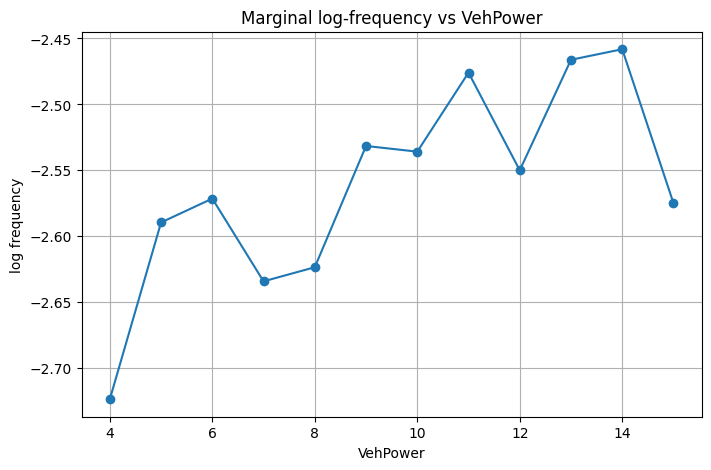

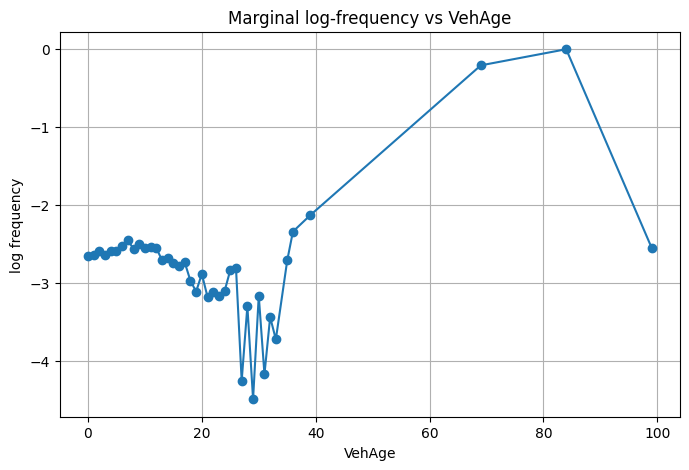

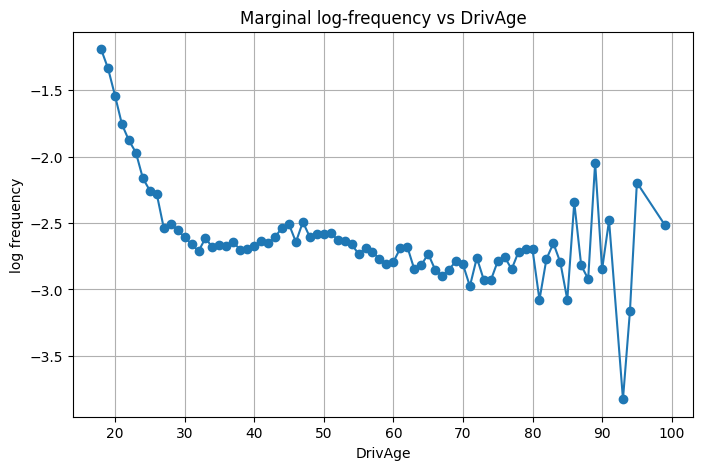

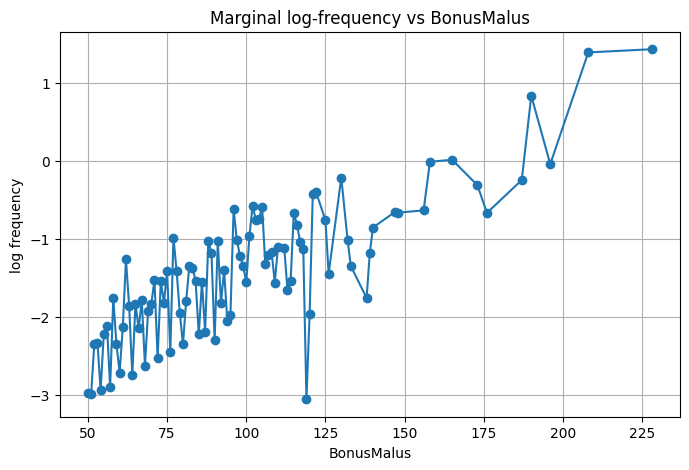

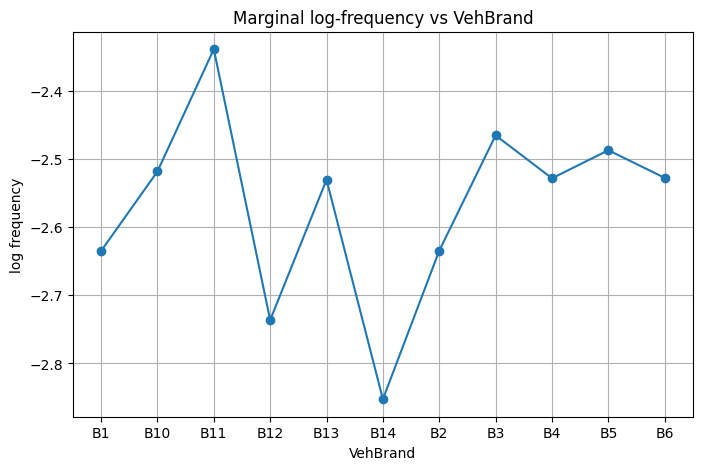

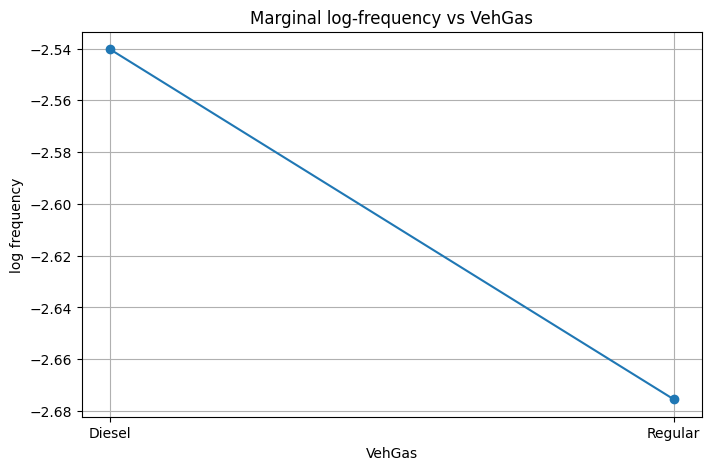

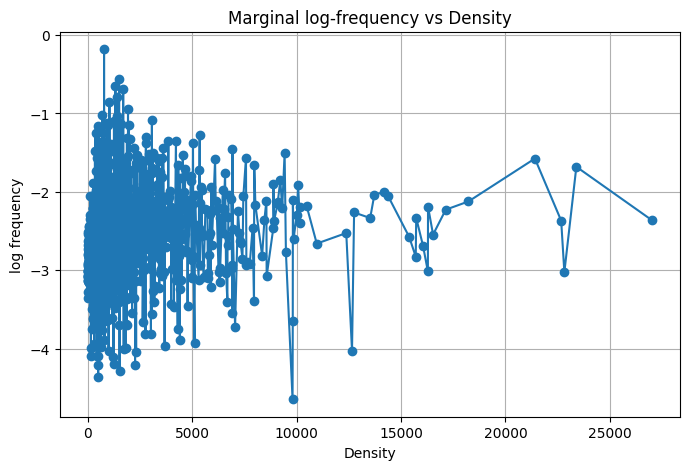

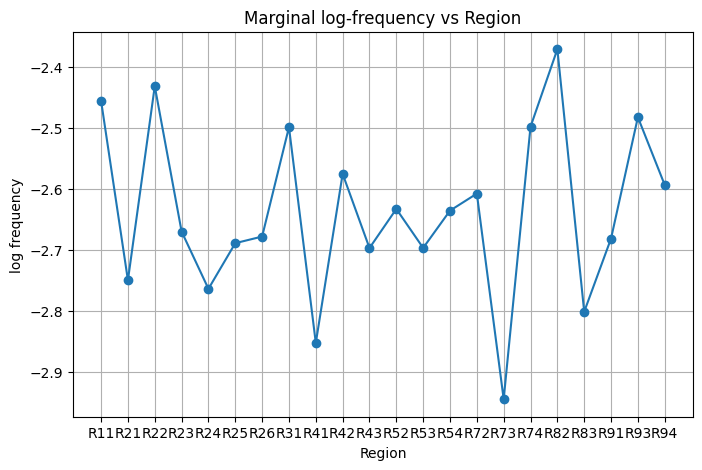

In [7]:
# Plot the empirical marginal log-frequencies
df = pd.concat([X_full, y_full], axis=1)
df = df[df["Exposure"] > 0]
features = X_full.columns

for feature in features:
    grouped = df.groupby(feature).agg({
        "ClaimNb": "sum",
        "Exposure": "sum"
    })

    # empirical frequency
    grouped["freq"] = grouped["ClaimNb"] / grouped["Exposure"]

    # remove zero-frequencies before log
    grouped = grouped[grouped["freq"] > 0]

    # log-frequency
    grouped["log_freq"] = np.log(grouped["freq"])

    # ---- Plot ----
    plt.figure(figsize=(8, 5))
    plt.plot(grouped.index, grouped["log_freq"], marker='o')
    plt.title(f"Marginal log-frequency vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("log frequency")
    plt.grid(True)
    plt.show()

In [8]:
# Propose feature transformations. Justify your choices

### Question 1.c

In [9]:
# Train a Poisson GLM using your feature transformations

# Print MAE, MSE and loss on train and test data sets

# Make sure your model outperforms the model of Question 1.a

# Exercise 2 (Poisson FNN)

### Question 2.a

In [26]:
# Neural network implementation

# Poisson Neural Network: ReLU hidden layers + exponential output
class PoissonNN(torch.nn.Module):
    """
    Feedforward neural network for Poisson regression.
    Architecture: input -> dense(100, ReLU) -> dense(100, ReLU) -> output(exp)
    """
    def __init__(self, input_dim, output_dim):
        super(PoissonNN, self).__init__()
        self.encoder = torch.nn.Linear(input_dim, 200)
        self.hidden_layer1 = torch.nn.Linear(200, 200)
        self.hidden_layer2 = torch.nn.Linear(200, 20)
        self.head = torch.nn.Linear(20, output_dim)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.encoder(x))
        x = self.relu(self.hidden_layer1(x))
        x = self.relu(self.hidden_layer2(x))
        x = self.head(x)
        x = torch.exp(x)  # exponential activation on output
        return x

#Model instantiation (adapt N and M to data dimensions)
N = X_encoded.shape[1]  # number of input features
print(f"Number of input features: {N}")
M = 1                    # number of output targets (ClaimFrequency/Exposure)

test_model = PoissonNN(input_dim=N, output_dim=M)
print(f"PoissonNN model created with input_dim={N}, output_dim={M}")
print(f"\nPoissonNN architecture:\n{test_model}")

Number of input features: 40
PoissonNN model created with input_dim=40, output_dim=1

PoissonNN architecture:
PoissonNN(
  (encoder): Linear(in_features=40, out_features=200, bias=True)
  (hidden_layer1): Linear(in_features=200, out_features=200, bias=True)
  (hidden_layer2): Linear(in_features=200, out_features=20, bias=True)
  (head): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)


### Question 2.b

In [9]:
# Train Poisson feedforward neural network model

from tqdm import tqdm

# Detect GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

X_train_tensor = torch.tensor(X_train.to_numpy(dtype=np.float32))
X_test_tensor = torch.tensor(X_test.to_numpy(dtype=np.float32))
y_train_tensor = torch.tensor(y_train["ClaimFrequency"].to_numpy(dtype=np.float32).reshape(-1, 1))
y_test_tensor = torch.tensor(y_test["ClaimFrequency"].to_numpy(dtype=np.float32).reshape(-1, 1))
exposure_train_tensor = torch.tensor(y_train["Exposure"].to_numpy(dtype=np.float32))
exposure_test_tensor = torch.tensor(y_test["Exposure"].to_numpy(dtype=np.float32))

print(f'type of X_train_tensor: {type(X_train_tensor)}, shape: {X_train_tensor.shape}')

# ============================================
#   PREPARE DATA (dataset_train is TensorDataset)
# ============================================
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device).squeeze()
y_test_tensor = y_test_tensor.to(device).squeeze()
exposure_train_tensor = exposure_train_tensor.to(device)
exposure_test_tensor = exposure_test_tensor.to(device)



Using device: cuda

type of X_train_tensor: <class 'torch.Tensor'>, shape: torch.Size([610206, 40])


In [10]:

# ============================================
#   CUSTOM LOSS
# ============================================

def loss_fn(lam, y, exposure):
    # add tiny eps for numerical stability
    eps = 1e-8
    # term1 = y * log(lam), zero where lam==0
    term1 = torch.where(y > 0, y * torch.log(lam), torch.zeros_like(y))
    # term2 = y * log(y), zero where y==0
    term2 = torch.where(y > 0, y * torch.log(y), torch.zeros_like(y))

    # Poisson deviance
    dev = 2.0 * (lam - y - term1 + term2)

    # exposure-weighted mean
    loss = torch.sum(exposure * dev) / (torch.sum(exposure) + eps)
    return loss




In [37]:
class PoissonTrainer:
    def __init__(self, model, loss_fn=loss_fn, lr=1e-2, batch_size=10000, n_epochs=100, milestones=[100, 500, 1000], n = N):
        """
        Trainer for Poisson GLMs or neural networks using a custom loss.

        """
        # Detect device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"[INFO] Using device: {self.device}")

        # Store parameters
        self.model = model.to(self.device)
        self.loss_fn = loss_fn
        self.lr = lr
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.milestones = milestones
        self.n = n

        # Optimizer + scheduler
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=self.milestones, gamma=0.1)

        self.epoch_losses = []

    # ------------------------------------------------------------
    # TRAIN METHOD
    # ------------------------------------------------------------
    def train(self, X_train, y_train, exposure_train):
        self.model.train()
        self.epoch_losses = []

        loop = tqdm(range(self.n_epochs))
        for epoch in loop:
            perm = torch.randperm(self.n, device=self.device)
            total_loss_accum = 0.0

            for i in range(0, self.n, self.batch_size):
                idx = perm[i:i + self.batch_size]
                batch_X = X_train[idx]
                batch_y = y_train[idx]
                batch_exp = exposure_train[idx]

                lam = self.model(batch_X).squeeze()
                loss = self.loss_fn(lam, batch_y, batch_exp)

                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                total_loss_accum += loss.detach()

            self.epoch_losses.append(total_loss_accum.item())
            loop.set_postfix(loss=total_loss_accum)

            self.scheduler.step()

        print("\nTraining completed!\n")

    # ------------------------------------------------------------
    # EVALUATION METHOD
    # ------------------------------------------------------------
    def evaluate(self, X_train, y_train, exposure_train,
                       X_test, y_test, exposure_test):

        self.model.eval()
        with torch.no_grad():
            lam_train = self.model(X_train.to(self.device)).squeeze().cpu().numpy()
            lam_test  = self.model(X_test.to(self.device)).squeeze().cpu().numpy()

        y_train_np = y_train.cpu().numpy()
        y_test_np  = y_test.cpu().numpy()
        exp_train_np = exposure_train.cpu().numpy()
        exp_test_np  = exposure_test.cpu().numpy()

        # Poisson deviance using custom loss
        train_poi_dev = self.loss_fn(
            torch.tensor(lam_train),
            torch.tensor(y_train_np),
            torch.tensor(exp_train_np),
        ).item()

        test_poi_dev = self.loss_fn(
            torch.tensor(lam_test),
            torch.tensor(y_test_np),
            torch.tensor(exp_test_np),
        ).item()

        # ---- Metrics ----
        print("=== TRAIN METRICS ===")
        print("MAE:", mean_absolute_error(y_train_np, lam_train, sample_weight=exp_train_np))
        print("MSE:", mean_squared_error(y_train_np, lam_train, sample_weight=exp_train_np))
        print("Exposure-weighted Poisson deviance (Sklearn):",
              mean_poisson_deviance(y_train_np, lam_train, sample_weight=exp_train_np))
        print("Exposure-weighted Poisson deviance (Torch custom):", train_poi_dev)

        print("\n=== TEST METRICS ===")
        print("MAE:", mean_absolute_error(y_test_np, lam_test, sample_weight=exp_test_np))
        print("MSE:", mean_squared_error(y_test_np, lam_test, sample_weight=exp_test_np))
        print("Exposure-weighted Poisson deviance (Sklearn):",
              mean_poisson_deviance(y_test_np, lam_test, sample_weight=exp_test_np))
        print("Exposure-weighted Poisson deviance (Torch custom):", test_poi_dev)

        return {
            "train": {
                "mae": mean_absolute_error(y_train_np, lam_train, sample_weight=exp_train_np),
                "mse": mean_squared_error(y_train_np, lam_train, sample_weight=exp_train_np),
                "dev_sklearn": mean_poisson_deviance(y_train_np, lam_train, sample_weight=exp_train_np),
                "dev_torch": train_poi_dev
            },
            "test": {
                "mae": mean_absolute_error(y_test_np, lam_test, sample_weight=exp_test_np),
                "mse": mean_squared_error(y_test_np, lam_test, sample_weight=exp_test_np),
                "dev_sklearn": mean_poisson_deviance(y_test_np, lam_test, sample_weight=exp_test_np),
                "dev_torch": test_poi_dev
            }
        }

    # ------------------------------------------------------------
    # LOSS-PLOT METHOD
    # ------------------------------------------------------------
    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.epoch_losses, label="Exposure-weighted Poisson deviance")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss per Epoch")
        plt.grid(True)
        plt.legend()
        plt.show()

    # ------------------------------------------------------------
    # FREE GPU
    # ------------------------------------------------------------
    def free_gpu(self):
        self.model = self.model.to("cpu")
        torch.cuda.empty_cache()


[INFO] Using device: cuda


100%|██████████| 100/100 [00:00<00:00, 217.84it/s, loss=tensor(0.0017, device='cuda:0')]




Training completed!

=== TRAIN METRICS ===
MAE: 0.07656927406787872
MSE: 0.2432725429534912
Exposure-weighted Poisson deviance (Sklearn): 2.1083672046661377
Exposure-weighted Poisson deviance (Torch custom): 2.1083667278289795

=== TEST METRICS ===
MAE: 0.07470466941595078
MSE: 0.2628171145915985
Exposure-weighted Poisson deviance (Sklearn): 2.039381980895996
Exposure-weighted Poisson deviance (Torch custom): 2.039381742477417
=== TRAIN METRICS ===
MAE: 0.07656927406787872
MSE: 0.2432725429534912
Exposure-weighted Poisson deviance (Sklearn): 2.1083672046661377
Exposure-weighted Poisson deviance (Torch custom): 2.1083667278289795

=== TEST METRICS ===
MAE: 0.07470466941595078
MSE: 0.2628171145915985
Exposure-weighted Poisson deviance (Sklearn): 2.039381980895996
Exposure-weighted Poisson deviance (Torch custom): 2.039381742477417


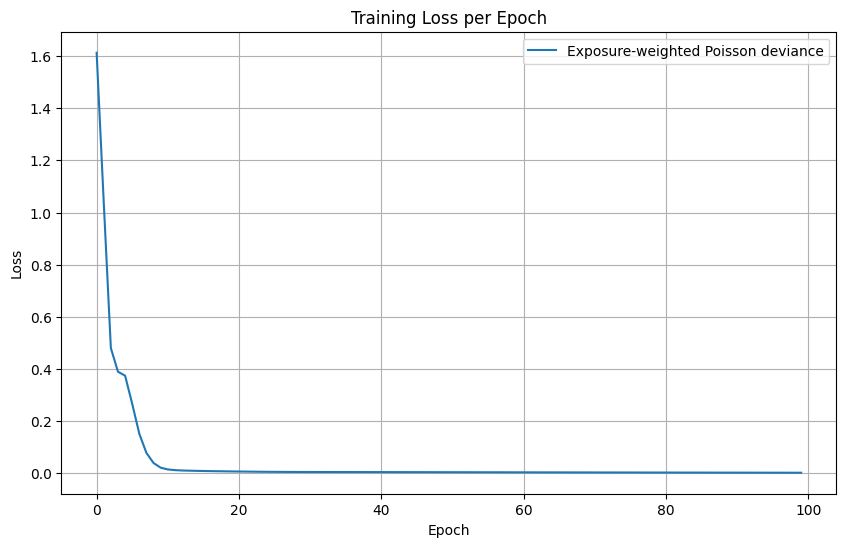

In [38]:
model = PoissonNN(input_dim=N, output_dim=M)
standardTrainer = PoissonTrainer(model=model)
standardTrainer.train(X_train_tensor, y_train_tensor, exposure_train_tensor)
standardTrainer.evaluate(X_train_tensor, y_train_tensor, exposure_train_tensor,
                         X_test_tensor, y_test_tensor, exposure_test_tensor)
standardTrainer.plot_losses()
 

[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.5600, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.2741, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.4608437120914459
MSE: 0.3723764717578888
Exposure-weighted Poisson deviance (Sklearn): 0.9265718460083008
Exposure-weighted Poisson deviance (Torch custom): 0.9265717267990112

=== TEST METRICS ===
MAE: 0.4599516987800598
MSE: 0.39373353123664856
Exposure-weighted Poisson deviance (Sklearn): 0.926069438457489
Exposure-weighted Poisson deviance (Torch custom): 0.9260692000389099
=== TRAIN METRICS ===
MAE: 0.4608437120914459
MSE: 0.3723764717578888
Exposure-weighted Poisson deviance (Sklearn): 0.9265718460083008
Exposure-weighted Poisson deviance (Torch custom): 0.9265717267990112

=== TEST METRICS ===
MAE: 0.4599516987800598
MSE: 0.39373353123664856
Exposure-weighted Poisson deviance (Sklearn): 0.926069438457489
Exposure-weighted Poisson deviance (Torch custom): 0.9260692000389099


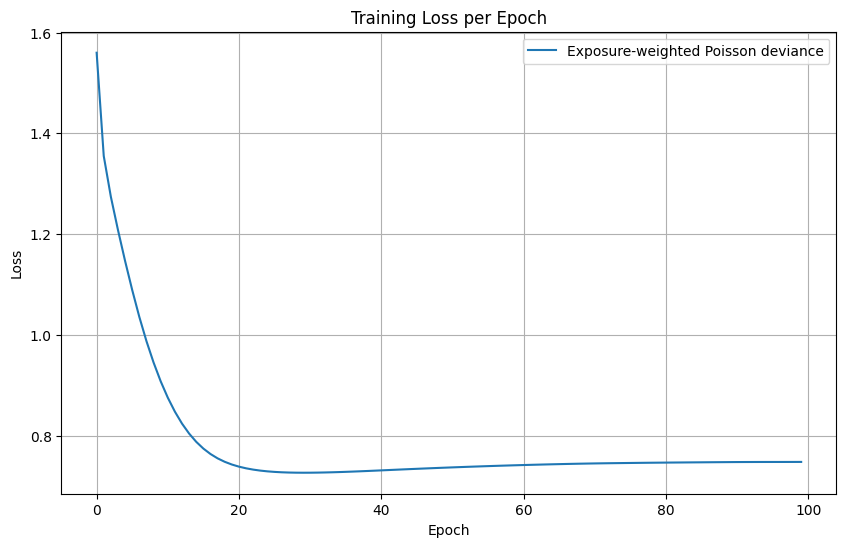

In [44]:
model = PoissonNN(input_dim=N, output_dim=M)
L2Trainer = PoissonTrainer(model=model)
L2Trainer.optimizer = torch.optim.AdamW(L2Trainer.model.parameters(), lr=L2Trainer.lr, weight_decay=30.0)
L2Trainer.train(X_train_tensor, y_train_tensor, exposure_train_tensor)
L2Trainer.evaluate(X_train_tensor, y_train_tensor, exposure_train_tensor,
                         X_test_tensor, y_test_tensor, exposure_test_tensor)
L2Trainer.plot_losses()
L2Trainer.free_gpu()

In [35]:
# Example weight_decay values to test
weight_decays = [0.001, 0.01, 0.1, 0.5, 1.0, 10.0]

# Number of folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store results for each weight_decay
cv_results = {}

# Convert tensors to numpy for indexing
X_np = X_train_tensor.cpu().numpy()
y_np = y_train_tensor.cpu().numpy()
exp_np = exposure_train_tensor.cpu().numpy()

for wd in weight_decays:
    print(f"\n=== Testing weight_decay={wd} ===")
    
    fold_metrics = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np)):
        print(f"\n--- Fold {fold+1}/{n_splits} ---")
        
        # Create fold tensors
        X_train_fold = torch.tensor(X_np[train_idx], dtype=X_train_tensor.dtype, device=DEVICE)
        y_train_fold = torch.tensor(y_np[train_idx], dtype=y_train_tensor.dtype, device=DEVICE)
        exp_train_fold = torch.tensor(exp_np[train_idx], dtype=exposure_train_tensor.dtype, device=DEVICE)
        
        X_val_fold = torch.tensor(X_np[val_idx], dtype=X_train_tensor.dtype, device=DEVICE)
        y_val_fold = torch.tensor(y_np[val_idx], dtype=y_train_tensor.dtype, device=DEVICE)
        exp_val_fold = torch.tensor(exp_np[val_idx], dtype=exposure_train_tensor.dtype, device=DEVICE)
        
        # Create new model for each fold
        model = PoissonNN(input_dim=N, output_dim=M)
        
        # Create trainer
        trainer = PoissonTrainer(model=model)
        
        # Set optimizer with weight_decay
        trainer.optimizer = torch.optim.AdamW(
            trainer.model.parameters(),
            lr=trainer.lr,
            weight_decay=wd
        )
        
        # Train
        trainer.train(X_train_fold, y_train_fold, exp_train_fold)
        
        # Evaluate on validation fold
        metrics = trainer.evaluate(
            X_train_fold, y_train_fold, exp_train_fold,
            X_val_fold, y_val_fold, exp_val_fold
        )
        
        fold_metrics.append(metrics['test'])  # store test (validation) metrics
        
        # Free GPU
        # trainer.free_gpu()
    
    # Average metrics across folds
    avg_metrics = {
        "mae": np.mean([m['mae'] for m in fold_metrics]),
        "mse": np.mean([m['mse'] for m in fold_metrics]),
        "dev_sklearn": np.mean([m['dev_sklearn'] for m in fold_metrics]),
        "dev_torch": np.mean([m['dev_torch'] for m in fold_metrics])
    }
    
    cv_results[wd] = avg_metrics
    print(f"\nAverage metrics for weight_decay={wd}: {avg_metrics}")

print("\n=== Cross-validation complete ===")



=== Testing weight_decay=0.001 ===

--- Fold 1/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7376, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7376, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07561589032411575
MSE: 0.2456160932779312
Exposure-weighted Poisson deviance (Sklearn): 2.9929146766662598
Exposure-weighted Poisson deviance (Torch custom): 2.992914915084839

=== TEST METRICS ===
MAE: 0.07508199661970139
MSE: 0.23184090852737427
Exposure-weighted Poisson deviance (Sklearn): 2.9967076778411865
Exposure-weighted Poisson deviance (Torch custom): 2.9967081546783447

--- Fold 2/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9372, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9372, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07595186680555344
MSE: 0.24075889587402344
Exposure-weighted Poisson deviance (Sklearn): 2.8524975776672363
Exposure-weighted Poisson deviance (Torch custom): 2.8524980545043945

=== TEST METRICS ===
MAE: 0.07672324031591415
MSE: 0.2528902590274811
Exposure-weighted Poisson deviance (Sklearn): 2.8668088912963867
Exposure-weighted Poisson deviance (Torch custom): 2.866809606552124

--- Fold 3/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.2922, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.2922, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.0734616369009018
MSE: 0.24102529883384705
Exposure-weighted Poisson deviance (Sklearn): 3.9976654052734375
Exposure-weighted Poisson deviance (Torch custom): 3.9976658821105957

=== TEST METRICS ===
MAE: 0.07624471932649612
MSE: 0.24928154051303864
Exposure-weighted Poisson deviance (Sklearn): 4.153350353240967
Exposure-weighted Poisson deviance (Torch custom): 4.153350353240967

--- Fold 4/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.2389, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.2389, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07617109268903732
MSE: 0.24658194184303284
Exposure-weighted Poisson deviance (Sklearn): 2.4385738372802734
Exposure-weighted Poisson deviance (Torch custom): 2.4385740756988525

=== TEST METRICS ===
MAE: 0.07198212295770645
MSE: 0.227238267660141
Exposure-weighted Poisson deviance (Sklearn): 2.322296142578125
Exposure-weighted Poisson deviance (Torch custom): 2.322296380996704

--- Fold 5/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1309, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1309, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07478725910186768
MSE: 0.2401464283466339
Exposure-weighted Poisson deviance (Sklearn): 2.0899181365966797
Exposure-weighted Poisson deviance (Torch custom): 2.089918375015259

=== TEST METRICS ===
MAE: 0.07566093653440475
MSE: 0.2525448203086853
Exposure-weighted Poisson deviance (Sklearn): 2.092195510864258
Exposure-weighted Poisson deviance (Torch custom): 2.0921952724456787

Average metrics for weight_decay=0.001: {'mae': np.float64(0.07513860315084457), 'mse': np.float64(0.24275915920734406), 'dev_sklearn': np.float64(2.8862717151641846), 'dev_torch': np.float64(2.8862719535827637)}

=== Testing weight_decay=0.01 ===

--- Fold 1/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1865, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1865, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07568866014480591
MSE: 0.24559779465198517
Exposure-weighted Poisson deviance (Sklearn): 3.6646785736083984
Exposure-weighted Poisson deviance (Torch custom): 3.6646780967712402

=== TEST METRICS ===
MAE: 0.07521242648363113
MSE: 0.2319229543209076
Exposure-weighted Poisson deviance (Sklearn): 3.6719541549682617
Exposure-weighted Poisson deviance (Torch custom): 3.6719541549682617

--- Fold 2/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.0946, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.0946, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07562749832868576
MSE: 0.24056661128997803
Exposure-weighted Poisson deviance (Sklearn): 2.8033714294433594
Exposure-weighted Poisson deviance (Torch custom): 2.8033711910247803

=== TEST METRICS ===
MAE: 0.0764228105545044
MSE: 0.2526548504829407
Exposure-weighted Poisson deviance (Sklearn): 2.81758713722229
Exposure-weighted Poisson deviance (Torch custom): 2.817587375640869

--- Fold 3/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.2645, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.2645, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07402199506759644
MSE: 0.2412298172712326
Exposure-weighted Poisson deviance (Sklearn): 4.114831447601318
Exposure-weighted Poisson deviance (Torch custom): 4.114831447601318

=== TEST METRICS ===
MAE: 0.07690858840942383
MSE: 0.24956469237804413
Exposure-weighted Poisson deviance (Sklearn): 4.266989231109619
Exposure-weighted Poisson deviance (Torch custom): 4.2669901847839355

--- Fold 4/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9517, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9517, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07566498219966888
MSE: 0.24661479890346527
Exposure-weighted Poisson deviance (Sklearn): 3.048893928527832
Exposure-weighted Poisson deviance (Torch custom): 3.0488944053649902

=== TEST METRICS ===
MAE: 0.07147606462240219
MSE: 0.22730490565299988
Exposure-weighted Poisson deviance (Sklearn): 2.9027607440948486
Exposure-weighted Poisson deviance (Torch custom): 2.9027605056762695

--- Fold 5/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.0622, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.0622, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.075191430747509
MSE: 0.2404252290725708
Exposure-weighted Poisson deviance (Sklearn): 3.234315872192383
Exposure-weighted Poisson deviance (Torch custom): 3.2343156337738037

=== TEST METRICS ===
MAE: 0.07609375566244125
MSE: 0.2528431713581085
Exposure-weighted Poisson deviance (Sklearn): 3.216820478439331
Exposure-weighted Poisson deviance (Torch custom): 3.216820240020752

Average metrics for weight_decay=0.01: {'mae': np.float64(0.07522272914648057), 'mse': np.float64(0.24285811483860015), 'dev_sklearn': np.float64(3.37522234916687), 'dev_torch': np.float64(3.3752224922180174)}

=== Testing weight_decay=0.1 ===

--- Fold 1/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1271, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1271, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.0750727653503418
MSE: 0.24562253057956696
Exposure-weighted Poisson deviance (Sklearn): inf
Exposure-weighted Poisson deviance (Torch custom): 3.840528964996338

=== TEST METRICS ===
MAE: 0.07451752573251724
MSE: 0.23187829554080963
Exposure-weighted Poisson deviance (Sklearn): inf
Exposure-weighted Poisson deviance (Torch custom): 3.8469507694244385

--- Fold 2/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.0187, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.0187, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07634478062391281
MSE: 0.24027828872203827
Exposure-weighted Poisson deviance (Sklearn): 1.892920970916748
Exposure-weighted Poisson deviance (Torch custom): 1.8929208517074585

=== TEST METRICS ===
MAE: 0.0771724283695221
MSE: 0.2524438202381134
Exposure-weighted Poisson deviance (Sklearn): 1.9060956239700317
Exposure-weighted Poisson deviance (Torch custom): 1.9060956239700317

--- Fold 3/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9807, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9807, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07392220944166183
MSE: 0.24113817512989044
Exposure-weighted Poisson deviance (Sklearn): 3.408534526824951
Exposure-weighted Poisson deviance (Torch custom): 3.408533811569214

=== TEST METRICS ===
MAE: 0.07673659175634384
MSE: 0.24941129982471466
Exposure-weighted Poisson deviance (Sklearn): 3.5398757457733154
Exposure-weighted Poisson deviance (Torch custom): 3.5398762226104736

--- Fold 4/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9649, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9649, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07691879570484161
MSE: 0.24671633541584015
Exposure-weighted Poisson deviance (Sklearn): 2.3394620418548584
Exposure-weighted Poisson deviance (Torch custom): 2.3394620418548584

=== TEST METRICS ===
MAE: 0.07274667173624039
MSE: 0.22741402685642242
Exposure-weighted Poisson deviance (Sklearn): 2.22578763961792
Exposure-weighted Poisson deviance (Torch custom): 2.22578763961792

--- Fold 5/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.4147, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.4147, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07542824745178223
MSE: 0.24015548825263977
Exposure-weighted Poisson deviance (Sklearn): 1.9583535194396973
Exposure-weighted Poisson deviance (Torch custom): 1.9583535194396973

=== TEST METRICS ===
MAE: 0.07630506902933121
MSE: 0.2525578737258911
Exposure-weighted Poisson deviance (Sklearn): 1.9546266794204712
Exposure-weighted Poisson deviance (Torch custom): 1.9546265602111816

Average metrics for weight_decay=0.1: {'mae': np.float64(0.07549565732479095), 'mse': np.float64(0.24274106323719025), 'dev_sklearn': np.float64(inf), 'dev_torch': np.float64(2.694667363166809)}

=== Testing weight_decay=0.5 ===

--- Fold 1/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9651, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.9651, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07578469067811966
MSE: 0.2452240288257599
Exposure-weighted Poisson deviance (Sklearn): 2.393699884414673
Exposure-weighted Poisson deviance (Torch custom): 2.3936996459960938

=== TEST METRICS ===
MAE: 0.07524316012859344
MSE: 0.2314731925725937
Exposure-weighted Poisson deviance (Sklearn): 2.3985493183135986
Exposure-weighted Poisson deviance (Torch custom): 2.3985495567321777

--- Fold 2/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6836, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6836, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07650735974311829
MSE: 0.24014812707901
Exposure-weighted Poisson deviance (Sklearn): 1.6191272735595703
Exposure-weighted Poisson deviance (Torch custom): 1.6191273927688599

=== TEST METRICS ===
MAE: 0.07732342183589935
MSE: 0.25233906507492065
Exposure-weighted Poisson deviance (Sklearn): 1.6302064657211304
Exposure-weighted Poisson deviance (Torch custom): 1.63020658493042

--- Fold 3/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.8760, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.8760, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07406873255968094
MSE: 0.24100029468536377
Exposure-weighted Poisson deviance (Sklearn): 2.2163941860198975
Exposure-weighted Poisson deviance (Torch custom): 2.2163937091827393

=== TEST METRICS ===
MAE: 0.07683607190847397
MSE: 0.2492683082818985
Exposure-weighted Poisson deviance (Sklearn): 2.304903745651245
Exposure-weighted Poisson deviance (Torch custom): 2.304903745651245

--- Fold 4/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7820, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7820, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07690156996250153
MSE: 0.2464461475610733
Exposure-weighted Poisson deviance (Sklearn): 1.5640846490859985
Exposure-weighted Poisson deviance (Torch custom): 1.5640850067138672

=== TEST METRICS ===
MAE: 0.07267051190137863
MSE: 0.22713440656661987
Exposure-weighted Poisson deviance (Sklearn): 1.4838756322860718
Exposure-weighted Poisson deviance (Torch custom): 1.4838756322860718

--- Fold 5/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1952, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1952, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.075617715716362
MSE: 0.23998050391674042
Exposure-weighted Poisson deviance (Sklearn): 1.5494980812072754
Exposure-weighted Poisson deviance (Torch custom): 1.5494983196258545

=== TEST METRICS ===
MAE: 0.07649281620979309
MSE: 0.25235193967819214
Exposure-weighted Poisson deviance (Sklearn): 1.5509631633758545
Exposure-weighted Poisson deviance (Torch custom): 1.550963282585144

Average metrics for weight_decay=0.5: {'mae': np.float64(0.07571319639682769), 'mse': np.float64(0.24251338243484497), 'dev_sklearn': np.float64(1.87369966506958), 'dev_torch': np.float64(1.8736997604370118)}

=== Testing weight_decay=1.0 ===

--- Fold 1/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.5830, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.5830, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07840617001056671
MSE: 0.24516494572162628
Exposure-weighted Poisson deviance (Sklearn): 1.6068079471588135
Exposure-weighted Poisson deviance (Torch custom): 1.6068083047866821

=== TEST METRICS ===
MAE: 0.0779712051153183
MSE: 0.23158590495586395
Exposure-weighted Poisson deviance (Sklearn): 1.6071499586105347
Exposure-weighted Poisson deviance (Torch custom): 1.6071497201919556

--- Fold 2/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7037, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7037, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07764571905136108
MSE: 0.24006770551204681
Exposure-weighted Poisson deviance (Sklearn): 1.4168471097946167
Exposure-weighted Poisson deviance (Torch custom): 1.416846752166748

=== TEST METRICS ===
MAE: 0.07854626327753067
MSE: 0.25230488181114197
Exposure-weighted Poisson deviance (Sklearn): 1.431949496269226
Exposure-weighted Poisson deviance (Torch custom): 1.431949496269226

--- Fold 3/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6453, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6453, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07471588253974915
MSE: 0.2408934384584427
Exposure-weighted Poisson deviance (Sklearn): 1.3890271186828613
Exposure-weighted Poisson deviance (Torch custom): 1.3890273571014404

=== TEST METRICS ===
MAE: 0.07749808579683304
MSE: 0.24917341768741608
Exposure-weighted Poisson deviance (Sklearn): 1.444928765296936
Exposure-weighted Poisson deviance (Torch custom): 1.4449290037155151

--- Fold 4/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1411, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.1411, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07750210911035538
MSE: 0.24637672305107117
Exposure-weighted Poisson deviance (Sklearn): 1.388659954071045
Exposure-weighted Poisson deviance (Torch custom): 1.388660192489624

=== TEST METRICS ===
MAE: 0.07329551130533218
MSE: 0.22710107266902924
Exposure-weighted Poisson deviance (Sklearn): 1.3184303045272827
Exposure-weighted Poisson deviance (Torch custom): 1.3184303045272827

--- Fold 5/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.8765, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.8765, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.07611352950334549
MSE: 0.24002531170845032
Exposure-weighted Poisson deviance (Sklearn): 1.4607748985290527
Exposure-weighted Poisson deviance (Torch custom): 1.4607747793197632

=== TEST METRICS ===
MAE: 0.07700670510530472
MSE: 0.2523825168609619
Exposure-weighted Poisson deviance (Sklearn): 1.460577368736267
Exposure-weighted Poisson deviance (Torch custom): 1.460577368736267

Average metrics for weight_decay=1.0: {'mae': np.float64(0.07686355412006378), 'mse': np.float64(0.24250955879688263), 'dev_sklearn': np.float64(1.4526071786880492), 'dev_torch': np.float64(1.4526071786880492)}

=== Testing weight_decay=10.0 ===

--- Fold 1/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7744, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7744, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.10383207350969315
MSE: 0.24989385902881622
Exposure-weighted Poisson deviance (Sklearn): 0.6895876526832581
Exposure-weighted Poisson deviance (Torch custom): 0.6895877718925476

=== TEST METRICS ===
MAE: 0.10333994776010513
MSE: 0.23610004782676697
Exposure-weighted Poisson deviance (Sklearn): 0.6864749193191528
Exposure-weighted Poisson deviance (Torch custom): 0.6864748597145081

--- Fold 2/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6885, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6885, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.099033422768116
MSE: 0.24015699326992035
Exposure-weighted Poisson deviance (Sklearn): 0.6795929670333862
Exposure-weighted Poisson deviance (Torch custom): 0.6795927882194519

=== TEST METRICS ===
MAE: 0.09957613795995712
MSE: 0.2521810829639435
Exposure-weighted Poisson deviance (Sklearn): 0.6859702467918396
Exposure-weighted Poisson deviance (Torch custom): 0.6859702467918396

--- Fold 3/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7065, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.7065, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.0837077796459198
MSE: 0.2409069836139679
Exposure-weighted Poisson deviance (Sklearn): 0.7857125401496887
Exposure-weighted Poisson deviance (Torch custom): 0.7857125401496887

=== TEST METRICS ===
MAE: 0.08644983172416687
MSE: 0.2491346001625061
Exposure-weighted Poisson deviance (Sklearn): 0.8166816830635071
Exposure-weighted Poisson deviance (Torch custom): 0.8166816830635071

--- Fold 4/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6036, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(1.6036, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.09191632270812988
MSE: 0.2462947964668274
Exposure-weighted Poisson deviance (Sklearn): 0.7547000646591187
Exposure-weighted Poisson deviance (Torch custom): 0.7547000646591187

=== TEST METRICS ===
MAE: 0.08776739984750748
MSE: 0.22710958123207092
Exposure-weighted Poisson deviance (Sklearn): 0.7175729870796204
Exposure-weighted Poisson deviance (Torch custom): 0.7175729274749756

--- Fold 5/5 ---
[INFO] Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.0300, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s, loss=tensor(2.0300, device='cuda:0')]C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0


Training completed!

=== TRAIN METRICS ===
MAE: 0.09298497438430786
MSE: 0.23940487205982208
Exposure-weighted Poisson deviance (Sklearn): 0.69332355260849
Exposure-weighted Poisson deviance (Torch custom): 0.6933236718177795

=== TEST METRICS ===
MAE: 0.09378615766763687
MSE: 0.25157055258750916
Exposure-weighted Poisson deviance (Sklearn): 0.6930055022239685
Exposure-weighted Poisson deviance (Torch custom): 0.6930054426193237

Average metrics for weight_decay=10.0: {'mae': np.float64(0.0941838949918747), 'mse': np.float64(0.24321917295455933), 'dev_sklearn': np.float64(0.7199410676956177), 'dev_torch': np.float64(0.7199410319328308)}

=== Cross-validation complete ===


In [36]:
# Display all cross-validation results
print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS - ALL WEIGHT_DECAY VALUES")
print("="*60)

for wd, metrics in cv_results.items():
    print(f"\nweight_decay = {wd}:")
    print(f"  {metrics}")

print("\n" + "="*60)
print("Full CV Results Dictionary:")
print(cv_results)



CROSS-VALIDATION RESULTS - ALL WEIGHT_DECAY VALUES

weight_decay = 0.001:
  {'mae': np.float64(0.07513860315084457), 'mse': np.float64(0.24275915920734406), 'dev_sklearn': np.float64(2.8862717151641846), 'dev_torch': np.float64(2.8862719535827637)}

weight_decay = 0.01:
  {'mae': np.float64(0.07522272914648057), 'mse': np.float64(0.24285811483860015), 'dev_sklearn': np.float64(3.37522234916687), 'dev_torch': np.float64(3.3752224922180174)}

weight_decay = 0.1:
  {'mae': np.float64(0.07549565732479095), 'mse': np.float64(0.24274106323719025), 'dev_sklearn': np.float64(inf), 'dev_torch': np.float64(2.694667363166809)}

weight_decay = 0.5:
  {'mae': np.float64(0.07571319639682769), 'mse': np.float64(0.24251338243484497), 'dev_sklearn': np.float64(1.87369966506958), 'dev_torch': np.float64(1.8736997604370118)}

weight_decay = 1.0:
  {'mae': np.float64(0.07686355412006378), 'mse': np.float64(0.24250955879688263), 'dev_sklearn': np.float64(1.4526071786880492), 'dev_torch': np.float64(1.4526

# Exercise 3 (Tree-based methods)

### Question 3.a

In [ ]:
# Implement a regression tree

# Cross-validation

# Print MAE, MSE and loss on train and test data sets

### Question 3.b

In [ ]:
# Implement a random forest model

# Cross-validation

# Print MAE, MSE and loss on train and test data sets

### Question 3.c

In [ ]:
# Implement gradient boosted trees

# Cross-validation

# Print MAE, MSE and loss on train and test data sets